<a href="https://colab.research.google.com/github/Arush0113/EEG_Pipeline-IITR/blob/main/RNNs%2C_LSTMs%2C_GRUs_and_Functional_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
print(tf.__version__)

print('GPU name: {}'.format(tf.test.gpu_device_name()))

2.5.0
GPU name: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Load and preprocess the IMDb data

In [3]:
def get_and_pad_imdb_dataset(num_words=10000, maxlen=None, index_from=2):
    from tensorflow.keras.datasets import imdb

    (x_train, y_train), (x_test, y_test) = imdb.load_data(path='imdb.npz',
                                                          num_words=num_words,
                                                          skip_top=0,
                                                          maxlen=maxlen,
                                                          start_char=1,
                                                          oov_char=2,
                                                          index_from=index_from)

    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        maxlen=None,
                                                        padding='pre',
                                                        truncating='pre',
                                                        value=0)
    
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                           maxlen=None,
                                                           padding='pre',
                                                           truncating='pre',
                                                           value=0)
    return (x_train, y_train), (x_test, y_test)

In [4]:
(x_train, y_train), (x_test, y_test) = get_and_pad_imdb_dataset()

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [5]:
def get_cyclic_generator(features, labels, batch_size = 1):
  while True:
    for n in range(features.shape[0]//batch_size):
      yield (features[n*batch_size: (n+1)*batch_size], labels[n*batch_size: (n+1)*batch_size])
    permuted = np.random.permutation(len(features))
    features = features[permuted]
    labels = labels[permuted]

In [6]:
train_batch_size = 32
train_cyclic_generator = get_cyclic_generator(x_train, y_train, batch_size = train_batch_size)
test_cyclic_generator = get_cyclic_generator(x_test, y_test, batch_size = train_batch_size)

In [7]:
def get_imdb_word_index(num_words=10000, index_from=2):
    imdb_word_index = tf.keras.datasets.imdb.get_word_index(
                                        path='imdb_word_index.json')
    imdb_word_index = {key: value + index_from for
                       key, value in imdb_word_index.items() if value <= num_words-index_from}
    return imdb_word_index

In [8]:
imdb_word_index = get_imdb_word_index()

In [9]:
inv_imdb_word_index = {value:key for key, value in imdb_word_index.items()}

In [10]:
list_100 = [inv_imdb_word_index[index] for index in x_train[100] if index>2]
sentence_100 = ' '.join(list_100)
sentence_100

"i am a great fan of david lynch and have everything that he's made on dvd except for hotel room the 2 hour twin peaks movie so when i found out about this i immediately grabbed it and and what is this it's a bunch of drawn black and white cartoons that are loud and foul mouthed and unfunny maybe i don't know what's good but maybe this is just a bunch of crap that was on the public under the name of david lynch to make a few bucks too let me make it clear that i didn't care about the foul language part but had to keep the sound because my neighbors might have all in all this is a highly disappointing release and may well have just been left in the box set as a curiosity i highly recommend you don't spend your money on this 2 out of 10"

In [11]:
y_train[100]

0

#### Build an Embedding layer into a model

In [12]:
max_index_value = max(imdb_word_index.values())
max_index_value

10000

In [13]:
embedding_dim = 16

In [37]:
# Functional API refresher: use the Model to build the same model

inp_shape = (None, )
review_sequence = tf.keras.Input(shape = inp_shape)
embedding_sequence = tf.keras.layers.Embedding(input_dim=max_index_value+1, output_dim=embedding_dim, input_shape=(review_sequence.shape), mask_zero=False)(review_sequence)
average_embedding = tf.keras.layers.GlobalAveragePooling1D()(embedding_sequence)
positive_probability = tf.keras.layers.Dense(units=1, activation='sigmoid', kernel_initializer='random_normal')(average_embedding)

model = tf.keras.Model(inputs = review_sequence, outputs = positive_probability) 

In [38]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


#### Compile, train, and evaluate the model

In [39]:
model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer='adam')

In [40]:
modelSavingPath = 'modelSavingPath/checkpoint_{epoch:02d}'

earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.005, patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = modelSavingPath,
    verbose = 1,
    save_weights_only = True,
    save_freq = 'epoch'
)

In [41]:
# history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test), validation_steps=20)

In [42]:
history = model.fit(
    train_cyclic_generator,
    steps_per_epoch= 768,
    epochs = 10,
    validation_data=test_cyclic_generator,
    validation_steps=20,
    callbacks=[earlyStoppingCallback, checkpoint]
    )

Epoch 1/10
768/768 [==============================] - 6s 7ms/step - loss: 0.6918 - accuracy: 0.5295 - val_loss: 0.6875 - val_accuracy: 0.6187

Epoch 00001: saving model to modelSavingPath/checkpoint_01
Epoch 2/10
768/768 [==============================] - 6s 7ms/step - loss: 0.6731 - accuracy: 0.6579 - val_loss: 0.6518 - val_accuracy: 0.7437

Epoch 00002: saving model to modelSavingPath/checkpoint_02
Epoch 3/10
768/768 [==============================] - 6s 8ms/step - loss: 0.6263 - accuracy: 0.7616 - val_loss: 0.5978 - val_accuracy: 0.7750

Epoch 00003: saving model to modelSavingPath/checkpoint_03
Epoch 4/10
768/768 [==============================] - 5s 7ms/step - loss: 0.5722 - accuracy: 0.7917 - val_loss: 0.5557 - val_accuracy: 0.8016

Epoch 00004: saving model to modelSavingPath/checkpoint_04
Epoch 5/10
768/768 [==============================] - 5s 7ms/step - loss: 0.5216 - accuracy: 0.8129 - val_loss: 0.5107 - val_accuracy: 0.8062

Epoch 00005: saving model to modelSavingPath/chec

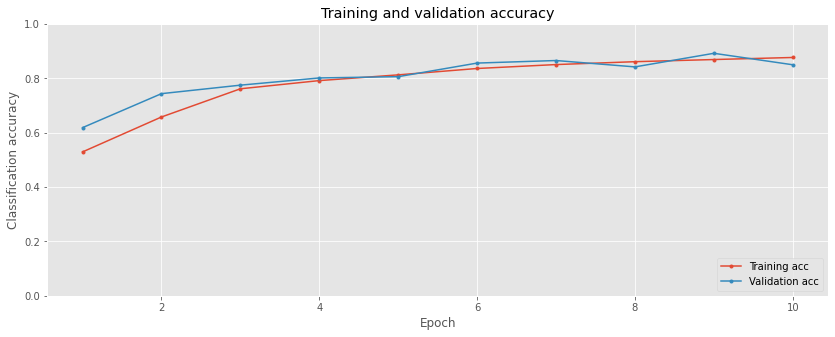

In [43]:
# Plot the training and validation accuracy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

history_dict = history.history

acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.plot(epochs, acc, marker='.', label='Training acc')
plt.plot(epochs, val_acc, marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1);

In [44]:
# Retrieve the embedding layer's weights from the trained model

weights = model.layers[1].get_weights()[0]

In [45]:
import io
from os import path

out_v = io.open(path.join('/content/drive/MyDrive', 'vecs.tsv'), 'w', encoding='utf-8')
out_m = io.open(path.join('/content/drive/MyDrive', 'meta.tsv'), 'w', encoding='utf-8')

k = 0

for word, token in imdb_word_index.items():
    if k != 0:
        out_m.write('\n')
        out_v.write('\n')
    
    out_v.write('\t'.join([str(x) for x in weights[token]]))
    out_m.write(word)
    k += 1
    
out_v.close()
out_m.close()
# beware large collections of embeddings!

---
<a id="coding_tutorial_5"></a>
## Recurrent neural network layers

In [46]:
# Create a SimpleRNN layer and test it

simple_rnn = tf.keras.layers.SimpleRNN(units = 16)

In [47]:
sequence = tf.constant([[[1.,1.],[2.,2.],[-56.,100.]]])  # dimesions of batch X sequence_length X n_elements_per_time_stamp
layer_output = simple_rnn(sequence)
layer_output

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[-1.        , -1.        ,  0.972092  ,  1.        ,  1.        ,
        -1.        ,  0.9999814 , -1.        , -0.98621035,  1.        ,
         0.9887967 , -1.        , -0.99384457, -1.        ,  1.        ,
         0.9985247 ]], dtype=float32)>

## Training using single LSTM layer

In [51]:
model = tf.keras.Sequential([
                     tf.keras.layers.Embedding(input_dim=max_index_value+1, output_dim= embedding_dim, mask_zero=True),
                     tf.keras.layers.LSTM(units = 16),
                     tf.keras.layers.Dense(units = 1, activation='sigmoid')
])

#### Compile and fit the model

In [52]:
model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

In [54]:
history = model.fit(
    train_cyclic_generator,
    steps_per_epoch= 32,
    epochs = 200,
    validation_data=test_cyclic_generator,
    validation_steps=20,
    callbacks=[earlyStoppingCallback, checkpoint]
)

Epoch 1/200
 2/32 [>.............................] - ETA: 2:37 - loss: 0.6924 - accuracy: 0.5625

KeyboardInterrupt: ignored

#### Plot learning curves

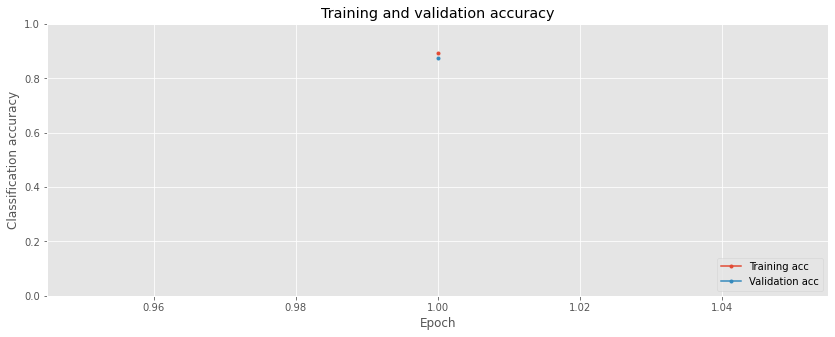

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

history_dict = history.history

acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.plot(epochs, acc, marker='.', label='Training acc')
plt.plot(epochs, val_acc, marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1);

#### Make predictions with the model

In [ ]:
# View the first test data example sentence
# (invert the word index)

inv_imdb_word_index = {val : key for key, val in imdb_word_index.items()}
first_review_list = [inv_imdb_word_index[index] for index in x_test[0] if index > 2]
first_review = ' '.join(first_review_list)
first_review

"please give this one a miss br br and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite so all you madison fans give this a miss"

In [ ]:
# Get the model prediction using model.predict()

model.predict(x_test[None,0,:])

array([[0.05665883]], dtype=float32)

In [ ]:
# Get the corresponding label

y_test[0]

0

---
<a id="coding_tutorial_6"></a>
## Stacked RNNs and the Bidirectional wrapper

#### Build stacked and bidirectional recurrent models

In [ ]:
# Using Sequential, build a stacked LSTM model via return_sequences=True

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim=max_index_value+1, output_dim=embedding_dim, mask_zero=True),
                             tf.keras.layers.LSTM(units=32, return_sequences=True),
                             tf.keras.layers.LSTM(units=32, return_sequences=False),
                             tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim=max_index_value+1, output_dim=embedding_dim, mask_zero = True),
                             tf.keras.layers.Bidirectional(layer=tf.keras.layers.LSTM(units=8), merge_mode='sum',
                                                           backward_layer=tf.keras.layers.GRU(units=8, go_backwards=True)),
                             tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim=max_index_value+1, output_dim=embedding_dim, mask_zero=True),
                             tf.keras.layers.Bidirectional(layer = tf.keras.layers.LSTM(units=8, return_sequences=True), merge_mode='concat'),
                             tf.keras.layers.GRU(units=8, return_sequences=False),
                             tf.keras.layers.Dense(units=1, activation='sigmoid')
])

#### Compile and fit the model

In [ ]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
history = model.fit(x_train, y_train, epochs=3, batch_size=32)

Epoch 1/3
  4/782 [..............................] - ETA: 3:20:24 - loss: 0.6925 - accuracy: 0.5312

KeyboardInterrupt: ignored

In [ ]:
# Plot the training and validation accuracy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

history_dict = history.history

acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.plot(epochs, acc, marker='.', label='Training acc')
plt.plot(epochs, val_acc, marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1);